# Energy-shaping and Linear Quadratic Regulgator for Pendulum

This example notebook shows Energy-shaping control for Pendulum and stabilization with LQR. For an extensive treatment of this concept see Chapters 2 and 3 of [1].

## Pendulum model
Consider a pendulum with a rigid rod of length $ L $ and a point mass $ m $ at the end. The pendulum is actuated by a torque $ u $ applied at the joint. The damping coefficient is $b$. A schematic is shown below

<img src="../media/pendulum.png" alt="pendulum" style="width: 300px;"/>

The dynamics of this pendulum are given by:

$$ m L^2 \ddot{\theta} + b \dot{\theta} + m g L \sin(\theta) = u, $$
where $ \theta $ is the angle of the pendulum with the vertical, $ g $ is the acceleration due to gravity, and $ L $ is the length of the rod. By defining $ \omega = \dot{\theta} $, and the state vector as:

\begin{equation}
x = 
\begin{bmatrix}
\theta \\ \omega
\end{bmatrix},
\end{equation}

the dynamics an be written as a set of first order differential equations:

\begin{equation}
\dot{x} = 
\begin{bmatrix}
\dot{\theta} \\ \dot{\omega}
\end{bmatrix} = 
f(x,u) = 
\begin{bmatrix}
\omega \\ -\dfrac{g}{L} \sin(\theta) - \dfrac{b}{m L^2} \omega +  \dfrac{u}{m L^2}
\end{bmatrix}.
\end{equation}

The model for the pendulum can be built either as a custom LeafSystem or from Collimator primitive blocks. For both these implementations, please see `collimator/models/pendulum.py`. You may also want to see the Collimator tutorials that showcase how to build models in Collimator.

## Energy-shaping

Energy-shaping is a control strategy that  manipulates the energy of the system to drive it to a desired configuration. The idea is to design a control law that shapes the energy of the system in such a way that the energy of the system converges to a desired energy level. 

For the pendulum, if our goal was to drive the pendulum to the upright position, we know that its total energy at the upright position is:

$$E_d =  m g L.$$

At a given state $x = [\theta \quad \omega]^T$, the energy of the system is:

$$ E = \frac12 m L^2 \omega^2 - m g L \cos(\theta).$$

For an undamped ($b=0$), the energy-shaping control law is of the form:

$$ u = -k\, \omega \,(E-E_d),$$

where $k$ is a positive gain parameter. The intuitive idea is that if $E-E_d$ is positive, i.e. the energy of the system is larger than desired, then we apply a torque in the negative direction to $\omega$, thus decreasing the energy of the system. Similarly, if  $E-E_d$ is negative, i.e. the energy of the system is lower than desired, then we apply a torque in the same direction as $\omega$, thus increasing the system's energy. The gain parameter $k$ controls how fast energy is pumped into, or out of, the system.

For the damped case $(b\neq 0)$, we add a term to cancel the damping:

$$ u = -k\, \omega \,(E-E_d) + b \omega.$$

See [1] for details including derivation of error dynamics.

To implement energy-shaping in Collimator we can create custom feed-through blocks by inheriting from `FeedthroughBlock`. This approach is shown below. We also add a Saturate block to limit the torque applied to the pendulum.

In [1]:
import control
import jax
import jax.numpy as jnp
import collimator

from collimator.library import linearize, FeedthroughBlock
from collimator.simulation import SimulatorOptions
from collimator.models import Pendulum, animate_pendulum

import matplotlib.pyplot as plt

In [2]:
def get_pendulum_energy(m, g, L, pendulum_state):
    """Returns the energy of the system at the pendulum_state"""
    theta = pendulum_state[0]
    omega = pendulum_state[1]
    return 0.5 * m * L**2 * omega**2 - m * g * L * jnp.cos(theta)


class PendulumEnergyShapingControl(FeedthroughBlock):
    """Compute Energy shaping control for Pendulum

    Computes `u = - k * omega * (E - Ed) + b * omega`
    where, E = (1/2)m*L**2 - m * g * L * cos(theta)

    Input ports:
        (0): Pendulum state [theta, omega]
    Output ports:
        (0): energy-shaping control `u`.

    Parmaeters:
        k: gain for energy-shaping control
        Ed: desired energy
        m: mass of the pendulum bob
        g: acceleration due to gravity
        L: length of the pendulum
        b: damping coefficient
    """

    def __init__(self, k, Ed, m, g, L, b, *args, **kwargs):
        self.k = k
        self.Ed = Ed
        self.m = m
        self.g = g
        self.L = L
        self.b = b
        super().__init__(self._energy_shaping_control, *args, **kwargs)

    def _energy_shaping_control(self, pendulum_state):
        omega = pendulum_state[1]
        E_err = get_pendulum_energy(self.m, self.g, self.L, pendulum_state) - self.Ed
        u = jnp.array([-1.0 * self.k * omega * E_err + self.b * omega])
        return u


class SaturateControl(FeedthroughBlock):
    """Clip the input between lower and upper limits

    Input ports:
        (0): x
    Output ports:
        (0): x clipped between lower_limit and upper_limit

    Parameters:
        lower_limit: lower limit for saturation
        upper_limit: upper limit for saturatn
    """

    def __init__(self, lower_limit, upper_limit, *args, **kwargs):
        self.lower_limit = lower_limit
        self.upper_limit = upper_limit
        super().__init__(
            lambda x: jnp.clip(x, self.lower_limit, self.upper_limit), *args, **kwargs
        )

In [3]:
x0 = jnp.array([0.0, 0.1])  # initial state

config = {"m": 1.0, "g": 9.81, "L": 1.0, "b": 0.0}  # Pendulum parameters

nx = 2  # state vector size
nu = 1  # control vector size

builder = collimator.DiagramBuilder()

plant = builder.add(Pendulum(x0=x0, **config, input_port=True, full_state_output=True))
controller = builder.add(
    PendulumEnergyShapingControl(
        0.1, config["m"] * config["g"] * config["L"], **config, name="controller"
    )
)

saturated_controller = builder.add(
    SaturateControl(lower_limit=-2.0, upper_limit=2.0, name="saturated_controller")
)

builder.connect(plant.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], saturated_controller.input_ports[0])
builder.connect(saturated_controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── Pendulum_1_ <Pendulum> [x → controller.in_0]
    │── controller <PendulumEnergyShapingControl> [out_0 → saturated_controller.in_0]
    │── saturated_controller <SaturateControl> [out_0 → Pendulum_1_.u]


In [4]:
context = diagram.create_context()

recorded_signals = {
    "y": plant.output_ports[0],
    "u_opt": controller.output_ports[0],
    "u_sat": saturated_controller.output_ports[0],
}

options = SimulatorOptions(max_major_step_length=0.1)

results = collimator.simulate(
    diagram,
    context,
    (0.0, 15.0),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO max_major_steps=298 based on smallest discrete period=0.1
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.1, max_major_steps=298, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


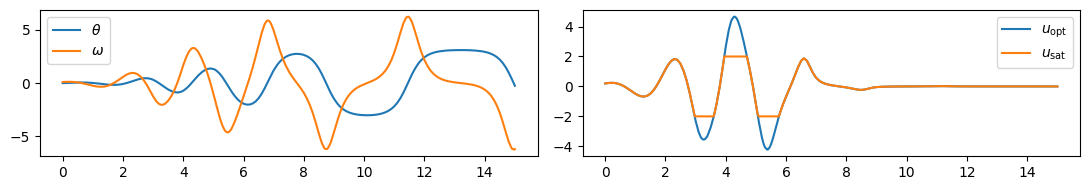

In [5]:
t = results.time
y = results.outputs["y"]
u_opt = results.outputs["u_opt"]
u_sat = results.outputs["u_sat"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2))
ax1.plot(t, y[:, 0], label=r"$\theta$")
ax1.plot(t, y[:, 1], label=r"$\omega$")
ax2.plot(t, u_opt, label=r"$u_\mathrm{opt}$")
ax2.plot(t, u_sat, label=r"$u_\mathrm{sat}$")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

We observe the oscillating pendulum, with its energy increasing. We can visualize the energy of the system below and animate the pendulum.

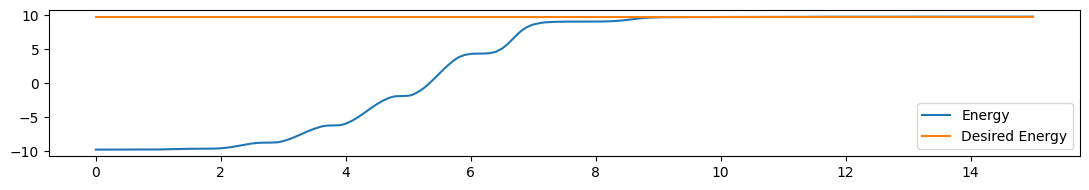

In [6]:
get_pendulum_energy_vec = jax.vmap(get_pendulum_energy, (None, None, None, 0))
fig, ax = plt.subplots(1, 1, figsize=(11, 2))
ax.plot(
    t, get_pendulum_energy_vec(config["m"], config["g"], config["L"], y), label="Energy"
)
ax.plot(
    t,
    config["m"] * config["g"] * config["L"] * jnp.ones_like(t),
    label="Desired Energy",
)
ax.legend(loc="lower right")
fig.tight_layout()
plt.show()

In [7]:
animate_pendulum(y[:, 0], u_sat, t, interval=20)

We observe that while the energy-shaping control has pumped sufficient amount of energy into the pendulum to reach the vertical orienation, the pendulum does not stabilize in the vertical orientation. To stabilize it, we need to switch to some other form of control when the pendulum is near the vertical orientation. Many different stabilization control algorithms, for example PID or LQR, may be used for this. In the section below we demonstrate LQR, which we have coverted previously.

## Switching from energy-shaping to LQR

We will implement a strategy with energy-shaping to pump enough energy and then switch to LQR for stabilization.

For the LQR, we first obtain a linear plant around the vertically-up equilibrium point.

### Linearize around the vertically-up orientation

In [8]:
# Equilibrium point for the up-orientation
u_eq = jnp.array([0.0])
x_eq = jnp.array([jnp.pi, 0.0])

pendulum = Pendulum(
    x0=x0, **config, input_port=True, full_state_output=True
)  # Create plant

# Fix the input_port to u_eq
with pendulum.input_ports[0].fixed(u_eq):
    # Create a base context
    base_context = pendulum.create_context()
    # Set the the continuous state to x_eq in the context
    eq_context = base_context.with_continuous_state(x_eq)
    # Call linearize for the pendulum plant and equilibrium context
    linear_pendulum = linearize(pendulum, eq_context)

A, B = linear_pendulum.A, linear_pendulum.B

Q = jnp.eye(nx)
R = 0.005 * jnp.eye(nu)

### Switching strategy

We will write a custom controller that switches from energy-shaping to LQR when the optimal cost-to-go for the LQR is below a threshold $q$ [1]. Recall from our example notebook on LQR that for the linear system:

$$ \dot{x} = Ax + Bu $$

the LQR minimizes the following cost function:

$$ J = \int_0^{\infty} (x^T Q x + u^T R u) dt, $$

by solving the Riccati Differential Equation (RDE):

$$ A^T S + SA - SBR^{-1}B^T S + Q = 0. $$

The LQR control law is then given by:

$$ u = -R^{-1}B^T S x = - K x, $$

where $ S $ is the solution to the RDE, and the optimal cost-to-go $J^*$, i.e. the minimum of $J$, is:

$$ J^* = x^T S x $$.

Thus, we start with the energy-shaping control and monitor $x^T S x$; when $x^T S x$ is low enough, determined by  $x^T S x< q$, where $q$ is a threshold, we switch the control to LQR. We can implement this combined controller as follows.

In [9]:
class EnergyShapingLQRSwitch(FeedthroughBlock):
    def __init__(
        self, k, Ed, m, g, L, b, linear_plant, x_eq, u_eq, Q, R, *args, **kwargs
    ):
        # Params for Energy Shaping
        self.k = k
        self.Ed = Ed
        self.m = m
        self.g = g
        self.L = L
        self.b = b

        # Params for LQR
        A, B = linear_plant.A, linear_plant.B
        K, self.S, E = control.lqr(A, B, Q, R)

        self.gain = -K
        self.x_eq = x_eq
        self.u_eq = u_eq

        super().__init__(self.get_energy_shaping_or_lqr_control, *args, **kwargs)

    def get_energy_shaping_or_lqr_control(self, x):
        x_wrapped = jnp.array([jnp.clip(x[0], 2 * jnp.pi) - jnp.pi, x[1]])
        x_bar = x - x_eq
        q = jnp.dot(x_bar, jnp.matmul(self.S, x_bar))
        pred = q < 1.8  # switching condition
        return jax.lax.cond(
            pred, self.get_lqr_control, self.get_energy_shaping_control, x
        )  # Switch

    def get_lqr_control(self, x):
        delta_x = x - x_eq  # transform state to delta_x around equilibrim
        delta_u = jnp.matmul(
            self.gain, delta_x
        )  # get LQR for delta_u, i.e. around equilibrium state
        u = delta_u + self.u_eq  # transform delta_u around equilibrium back to u
        return u

    def get_energy_shaping_control(self, x):
        omega = x[1]
        E_err = get_pendulum_energy(self.m, self.g, self.L, x) - self.Ed
        u = jnp.array([-1.0 * self.k * omega * E_err + self.b * omega])
        return u

We can now simulate our system with the above control as follows:

In [10]:
builder = collimator.DiagramBuilder()

plant = builder.add(Pendulum(x0=x0, **config, input_port=True, full_state_output=True))
controller = builder.add(
    EnergyShapingLQRSwitch(
        0.1,
        config["m"] * config["g"] * config["L"],
        config["m"],
        config["g"],
        config["L"],
        config["b"],
        linear_pendulum,
        x_eq,
        u_eq,
        Q,
        R,
        name="controller",
    )
)
saturated_controller = builder.add(
    SaturateControl(lower_limit=-6.0, upper_limit=6.0, name="saturated_controller")
)


builder.connect(plant.output_ports[0], controller.input_ports[0])
builder.connect(controller.output_ports[0], saturated_controller.input_ports[0])
builder.connect(saturated_controller.output_ports[0], plant.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── Pendulum_7_ <Pendulum> [x → controller.in_0]
    │── controller <EnergyShapingLQRSwitch> [out_0 → saturated_controller.in_0]
    │── saturated_controller <SaturateControl> [out_0 → Pendulum_7_.u]


**Note:** One needs to be careful with the torque limits here since the basic LQR, as implemented above, is unconstrained. Thus, if control input is saturated while LQR is active then the performance may not be ideal. One may remedy this by either considering a constrained LQR, or replacing the LQR with a different controller.

In [11]:
context = diagram.create_context()

recorded_signals = {
    "y": plant.output_ports[0],
    "u_opt": controller.output_ports[0],
    "u_sat": saturated_controller.output_ports[0],
}

results = collimator.simulate(
    diagram,
    context,
    (0.0, 10.0),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO max_major_steps=198 based on smallest discrete period=0.1
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.1, max_major_steps=198, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=Diagram(root, 3 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


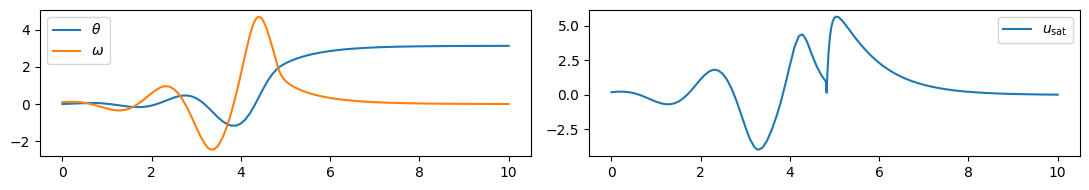

In [12]:
t = results.time
y = results.outputs["y"]
u_opt = results.outputs["u_opt"]
u_sat = results.outputs["u_sat"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2))
ax1.plot(t, y[:, 0], label=r"$\theta$")
ax1.plot(t, y[:, 1], label=r"$\omega$")
# ax2.plot(t, u_opt, label=r"$u_\mathrm{opt}$")
ax2.plot(t, u_sat, label=r"$u_\mathrm{sat}$")
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

In [13]:
animate_pendulum(y[:, 0], u_sat, t, interval=20)

The energy-shaping control pumps energy into the system and once we are close to the vertical orientation, we switch to LQR, which stabilizes the system. The switch happens at approximately $t=4.5$s.

**References**:
> [1] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). [Available online.](https://underactuated.csail.mit.edu/)